In [110]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Introduction to Pytorch
## FIFA dataset

<img src='https://github.com/DAI3862/DNN/images/prasami_color_tutorials_small.png?raw=1' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [111]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')
from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from utils.helper import fn_plot_torch_hist, fn_plot_confusion_matrix


In [112]:
print (fn_plot_torch_hist.__doc__)

None


In [113]:
print (fn_plot_confusion_matrix.__doc__)


    Args:
        y_true: Ground Truth 
        y_pred : Predictions
        labels : dictonary 
                  {0: 'Goal Keeper', 
                  1: 'Defender', 
                  2: 'Mid-Fielder', 
                  3: 'Forward'}
    
    


In [114]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'datasets/fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 101 # number of epochs
BATCH_SIZE = 32
ALPHA = 0.001 # learning rate
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'medium',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Basic Hygiene

In [115]:
# Check if all directories are present
if not os.path.exists(os.path.join(outDir)):
    os.makedirs(os.path.join(outDir))
    print ('Created {} directory'.format(outDir))

if not os.path.exists(os.path.join(modelDir, subDir)):
    os.makedirs(os.path.join(modelDir, subDir))
    print ('Created {} directory'.format(os.path.join(modelDir, subDir)))

## Read FIFA 2019 data set

In [116]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [117]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18207 entries, 0 to 18206
Data columns (total 89 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                18207 non-null  int64  
 1   ID                        18207 non-null  int64  
 2   Name                      18207 non-null  object 
 3   Age                       18207 non-null  int64  
 4   Photo                     18207 non-null  object 
 5   Nationality               18207 non-null  object 
 6   Flag                      18207 non-null  object 
 7   Overall                   18207 non-null  int64  
 8   Potential                 18207 non-null  int64  
 9   Club                      17966 non-null  object 
 10  Club Logo                 18207 non-null  object 
 11  Value                     18207 non-null  object 
 12  Wage                      18207 non-null  object 
 13  Special                   18207 non-null  int64  
 14  Prefer

In [118]:
data_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,18207.0,9103.000000,5256.052511,0.0,4551.5,9103.0,13654.5,18206.0
ID,18207.0,214298.338606,29965.244204,16.0,200315.5,221759.0,236529.5,246620.0
Age,18207.0,25.122206,4.669943,16.0,21.0,25.0,28.0,45.0
Overall,18207.0,66.238699,6.908930,46.0,62.0,66.0,71.0,94.0
Potential,18207.0,71.307299,6.136496,48.0,67.0,71.0,75.0,95.0
Special,18207.0,1597.809908,272.586016,731.0,1457.0,1635.0,1787.0,2346.0
International Reputation,18159.0,1.113222,0.394031,1.0,1.0,1.0,1.0,5.0
Weak Foot,18159.0,2.947299,0.660456,1.0,3.0,3.0,3.0,5.0
Skill Moves,18159.0,2.361308,0.756164,1.0,2.0,2.0,3.0,5.0
Jersey Number,18147.0,19.546096,15.947765,1.0,8.0,17.0,26.0,99.0


In [119]:
data_df.isna().sum().sum()

76984

In [120]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [121]:
data_df[data_df['Name']=="S. Chhetri"]

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
8605,8605,190939,S. Chhetri,33,https://cdn.sofifa.org/players/4/19/190939.png,India,https://cdn.sofifa.org/flags/159.png,67,67,NaN,...,67.0,30.0,24.0,44.0,10.0,7.0,11.0,9.0,10.0,NaN


In [122]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

In [123]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [124]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [125]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,3,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,3,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,3,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,0,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,2,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [126]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [127]:
features_df = data_df.drop('Position', axis=1)
labels_df = data_df['Position'].to_numpy()

In [128]:
# splitting in train ans test datasets
X_train, X_test, y_train, y_test = train_test_split(features_df,
                                     labels_df,
                                     stratify=labels_df,
                                     test_size=TEST_SIZE,
                                     random_state=RANDOM_STATE)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14517, 33), (3630, 33), (14517,), (3630,))

In [129]:
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [130]:
# important to reset the indies as we will be fetching by index

# train_df = train_df.reset_index(drop=True)
display (X_train)

# test_df = test_df.reset_index(drop=True)
display(X_test)

array([[ 0.84396466,  0.27358763, -0.52239617, ..., -0.37748688,
        -0.25744747, -0.31840455],
       [ 0.4854738 , -0.58924402, -0.04661844, ..., -0.62037214,
        -0.43407708, -0.37415646],
       [ 0.53668678, -0.93437669,  0.15728631, ..., -0.4382082 ,
        -0.43407708, -0.15114884],
       ...,
       [-1.87032331, -2.37242944, -2.15363411, ...,  2.17280829,
         2.15649058,  2.24618307],
       [-1.87032331, -1.96977467, -1.54191988, ...,  3.1443493 ,
         2.50974981,  2.74795021],
       [-1.30698052, -2.142341  , -2.35753885, ...,  3.08362799,
         3.03963865,  3.08246164]])

array([[ 1.04881658, -1.10694302,  0.90493703, ..., -0.013159  ,
        -0.61070669, -0.37415646],
       [ 1.30488148, -0.53172191,  0.63306404, ..., -0.19532294,
        -0.61070669, -0.48566027],
       [ 1.10002956, -0.53172191,  0.15728631, ..., -0.07388032,
        -0.25744747, -0.20690075],
       ...,
       [ 0.07576995, -0.30163347,  0.08931806, ..., -0.55965083,
        -0.55183016, -0.26265265],
       [ 1.04881658,  0.84880873,  1.31274651, ..., -0.31676557,
        -0.55183016, -0.59716408],
       [ 0.02455697,  1.25146351,  0.97290528, ..., -0.13460163,
        -0.61070669, -0.26265265]])

In [131]:
list(labels.keys())

[0, 1, 2, 3]

In [132]:
import torch

In [133]:
torch.__version__

'2.3.0+cpu'

In [134]:
torch.cuda.is_available()

False

In [135]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Define Dataset

In [144]:
class FifaDataset(Dataset):
    def __init__(self, X, y ):
        self.X = torch.tensor(X, dtype= torch.float32) # Convert Data to tensor
        self.y = torch.tensor(y, dtype = torch.long) # Convert Labels to tensors

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    


In [146]:
# Create Instanc eof object
train_dataset = FifaDataset(X_train, y_train)

# Create a dataloader with the batch size of 2 (u can adjust this)
train_loader = DataLoader(dataset= train_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle = True)

# Initiate the DataLoader
for batch_idx, (data,target) in enumerate(train_loader):
    print(f'Batch {batch_idx + 1}: ', end=" ")
    print("Data: ", data.shape, end=' ')
    print('Target: ', target.shape)


Batch 1:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 2:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 3:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 4:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 5:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 6:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 7:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 8:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 9:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 10:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 11:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 12:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 13:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 14:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 15:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 16:  Data:  torch.Size([32, 

In [149]:
# Create Instanc eof object
test_dataset = FifaDataset(X_test, y_test)

# Create a dataloader with the batch size of 2 (u can adjust this)
test_loader = DataLoader(dataset= test_dataset, 
                          batch_size = BATCH_SIZE,
                          shuffle = True)

# Initiate the DataLoader
for batch_idx, (data,target) in enumerate(test_loader):
    print(f'Batch {batch_idx + 1}: ', end=" ")
    print("Data: ", data.shape, end=' ')
    print('Target: ', target.shape)


Batch 1:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 2:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 3:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 4:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 5:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 6:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 7:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 8:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 9:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 10:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 11:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 12:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 13:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 14:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 15:  Data:  torch.Size([32, 33]) Target:  torch.Size([32])
Batch 16:  Data:  torch.Size([32, 

In [150]:
class Model (nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__inti__()
        self.layer1 = nn.Linear(input_dim, 18)
        self.active1 = nn.SILU()
        self.layer2 = nn.Linear(18,4)

    def forward(self, x):
        x = self.layer1(x) # level 1 aggregation
        x = self.activ1(x) # layer activation
        x = self.layer2(x) # layer 2 activation
        return x

In [153]:
loss_fn = nn.CrossEntropyLoss()

# Optimization
optimizer = torch.optim.Adam(model.parameters(), lr = ALPHA)

# Itrations
for epoch in range(EPOCHS):
    model.train() #set the model in training mode

    for batch_idx, (train_X, train_y) in enumerate(train_loader):
        train_X, train_y = train_X.to(device), train_y.to(device)
        predict_prob = model(train_X) # make predictions
        curr_loss = loss_fn(predict_prob, train_y) # calculate

        #### BAck Propagation


In [ ]:
input_dim = X_train.shape[1]

model = nn.Sequential(
    nn.Linear(input_dim, 18),
    nn.Tanh(),
    nn.Linear(18, 4)).to(device=device)

In [ ]:
model

Sequential(
  (0): Linear(in_features=33, out_features=18, bias=True)
  (1): Tanh()
  (2): Linear(in_features=18, out_features=4, bias=True)
)

In [ ]:
list(model.parameters())

[Parameter containing:
 tensor([[ 2.9992e-02, -7.6477e-02,  1.2812e-01, -1.6032e-01, -2.5596e-02,
           1.1986e-01,  3.4484e-02, -2.7163e-02,  1.1292e-01,  1.8864e-03,
           3.5920e-02, -3.6349e-02, -1.3615e-01, -6.3692e-02,  1.2890e-01,
          -4.4353e-02,  8.2581e-04, -1.0587e-01,  1.7264e-01,  9.8786e-02,
          -1.6303e-01,  2.8760e-02,  7.3949e-02,  1.6592e-01, -1.3994e-01,
          -7.5945e-02, -1.5446e-01,  1.3175e-01,  1.0946e-02,  5.8628e-02,
          -9.7354e-02, -5.2988e-03,  1.7319e-01],
         [ 4.3328e-02, -5.6639e-02, -1.4291e-01, -1.6964e-02,  1.5399e-01,
           7.2574e-02,  3.8422e-02,  2.4128e-02,  1.2324e-01,  6.9352e-02,
           1.0102e-01,  1.2315e-01, -1.7222e-01, -4.3276e-02,  1.1770e-01,
          -9.6776e-02,  2.2521e-02, -7.2398e-02, -4.1153e-02, -9.0923e-02,
           8.5224e-02,  6.2410e-02,  6.8948e-02, -5.1546e-03, -4.9265e-02,
           5.8001e-02,  8.9938e-02,  1.5947e-01,  7.5052e-02, -1.6999e-01,
           1.1695e-01,  4.8

In [ ]:
print(f'Run Parameters:  {len(list(model.parameters()))}')
print(f'Layer 1: Weights: {list(model.parameters())[0].shape}')
print(f'Layer 1: Biases: {list(model.parameters())[1].shape}')
print(f'Layer 2: Weights: {list(model.parameters())[2].shape}')
print(f'Layer 2: Biases: {list(model.parameters())[3].shape}')


Run Parameters:  4
Layer 1: Weights: torch.Size([18, 33])
Layer 1: Biases: torch.Size([18])
Layer 2: Weights: torch.Size([4, 18])
Layer 2: Biases: torch.Size([4])


In [ ]:
train_X = torch.tensor(X_train, dtype = torch.float32, device=device)
train_y = torch.tensor(y_train, dtype = torch.int64, device=device)

test_X = torch.tensor(X_test, dtype = torch.float32, device=device)
test_y = torch.tensor(y_test, dtype = torch.int64, device=device)

In [ ]:
type(y_test) # make sure y_test is numpy.ndarray

numpy.ndarray

In [ ]:
train_X[:1].shape, train_X[0].shape

(torch.Size([1, 33]), torch.Size([33]))

In [ ]:
 train_X.shape

torch.Size([14517, 33])

In [ ]:
predict_prob = model(train_X[:1]) # make pretictions
predict_prob.detach().cpu().numpy() # if on local machine remove .cpu()

array([[ 0.12332715, -0.19371115,  0.01286326, -0.42288965]],
      dtype=float32)

In [ ]:
y_train[0 ]

3

Training

In [ ]:
# # loss function
# loss_fn = nn.CrossEntropyLoss()

# # optimizer
# optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)

# # itterations
# for epoch in range(EPOCHS):
#   model.train() # Set model in training mode

#   predict_proba = model(train_X) # make predicetions

#   curr_loss = loss_fn(predict_proba, train_y) # calculate loss

#   ### Back Propagation Step
#   optimizer.zero_grad()
#   curr_loss.backward()
#   optimizer.step()


In [ ]:
predict_prob = model(train_X[:1]) # make pretictions
predict_prob.detach().cpu().numpy() # if on local machine remove .cpu()

array([[ 0.12332715, -0.19371115,  0.01286326, -0.42288965]],
      dtype=float32)

In [ ]:
y_train[0 ], predict_prob[0].argmax()

(3, tensor(0))

In [ ]:
# loss function
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=ALPHA)
# Adam: Adaptive, Momemtum, Stochastic(for each)

# Some lists to collects data
loss = []
tloss = []
n_epoch = []
acc = []
tacc = []

# iterations
for epoch in range(EPOCHS):
  model.train() # Set model in training mode

  predict_prob = model(train_X) # make predicetions

  curr_loss = loss_fn(predict_prob, train_y) # calculate loss

  ### Back Propagation Step
  optimizer.zero_grad() # re-initialize all values of the optimizer
  curr_loss.backward() # compute
  optimizer.step() #

  loss.append(curr_loss.data.item()) # appemd to loss list

  _, y_pred = torch.max(predict_prob, 1) # get the predicted class from the train model

  curr_acc = accuracy_score( y_train, y_pred.data.cpu()) # moVe to CPU

  acc.append(curr_acc) # append to accuracy list

  model.eval() # evaluate model, prevent form learning

  predict_prob_tst = model(test_X) # make predictions on test data

  tcurr_loss = loss_fn(predict_prob_tst, test_y)

  tloss.append(tcurr_loss.data.item()) # append to loss list

  _, y_pred = torch.max(predict_prob_tst, 1) # get predicte class from the

  tcurr_acc = accuracy_score(y_test, y_pred.data.cpu())# moVe to CPU

  tacc.append(tcurr_acc) # append to accuracy list

  n_epoch.append(epoch)

  if epoch % 1000 == 0:
    fmtStr = 'Epoch :{:5d}/{:5d} --- Loss: {:.5f}/{:.5f} | Acc {:.5f}/{:.5f}'
    print(fmtStr.format(epoch, EPOCHS,
                             curr_loss.data.item(),
                             tcurr_loss.data.item(),
                             curr_acc,
                             tcurr_acc))




Epoch :    0/  101 --- Loss: 1.53367/1.50916 | Acc 0.08149/0.09587


In [ ]:
loss_df = pd.DataFrame({'epoch': n_epoch,
                       'loss' : loss,
                       'test_loss' : tloss,
                       'acc' : acc,
                       'test_acc': tacc})

In [ ]:
loss_df.head()

,epoch,loss,test_loss,acc,test_acc
0,0,1.533673,1.509156,0.081491,0.095868
1,1,1.511971,1.487771,0.093477,0.109917
2,2,1.490649,1.466783,0.109251,0.127824
3,3,1.469722,1.446201,0.127161,0.152066
4,4,1.449200,1.426037,0.146587,0.173554


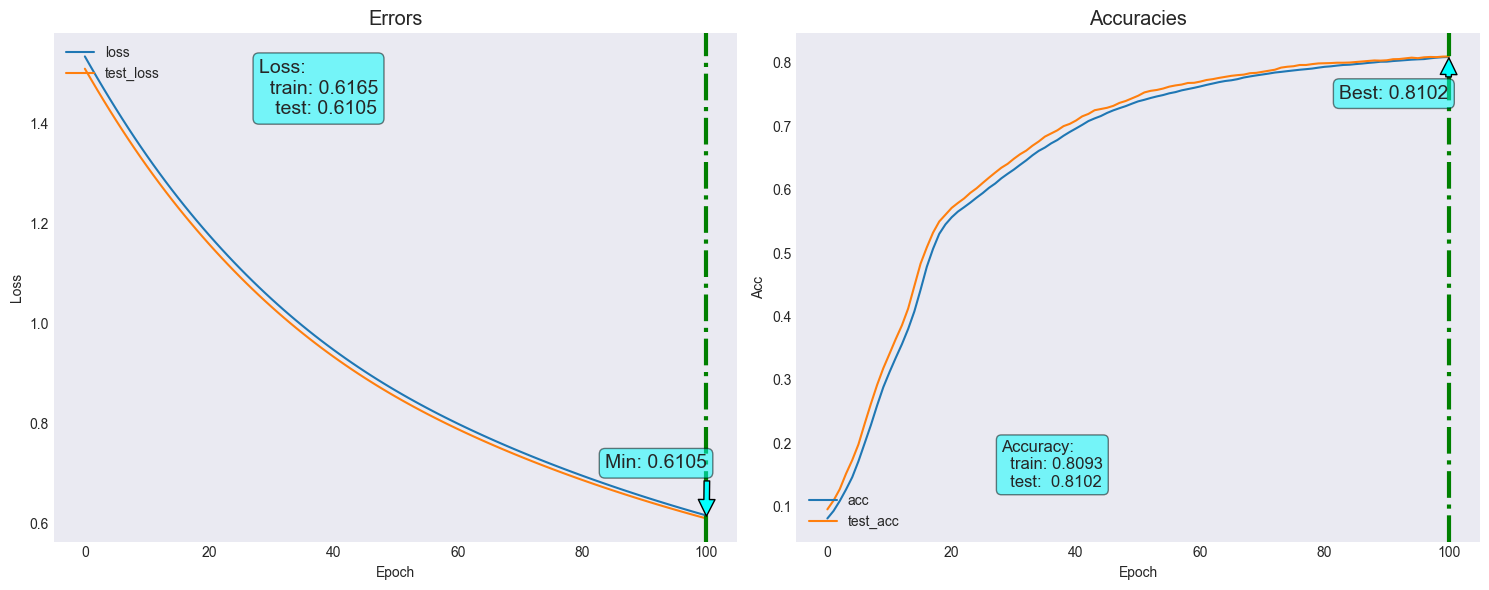

In [ ]:
fn_plot_torch_hist(loss_df)

In [ ]:
outputs = model(train_X)

y_pred = torch.argmax(outputs, dim = 1).cpu().numpy()

y_pred

array([3, 2, 2, ..., 0, 0, 0], dtype=int64)

In [ ]:
print(classification_report(train_y.cpu().numpy(), y_pred ))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.80      0.88      0.84      4693
           2       0.75      0.75      0.75      5470
           3       0.85      0.70      0.77      2734

    accuracy                           0.81     14517
   macro avg       0.85      0.83      0.84     14517
weighted avg       0.81      0.81      0.81     14517



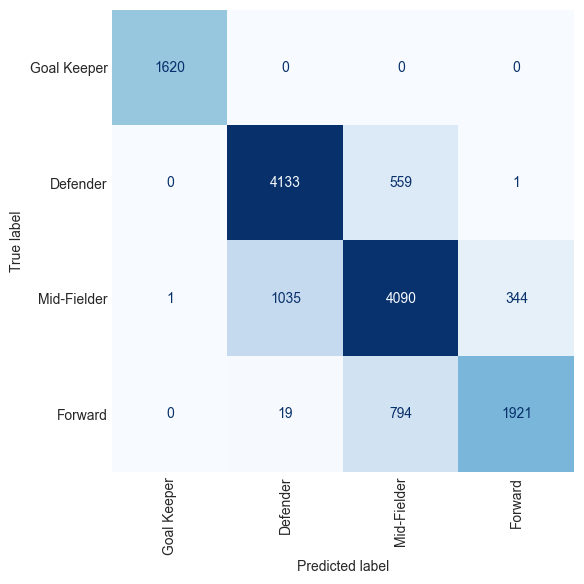

In [ ]:
fn_plot_confusion_matrix(train_y.cpu().numpy(), y_pred, labels=labels)

In [ ]:
torch.save(model, 'tensor.pt')